In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

# own modules
from models import * 
from utils import * 
from data_loader import PH2, DRIVE

In [3]:
import numpy as np

# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Training Parameters 

In [5]:
size = 256
batch_size = 16
num_epochs = 200

In [6]:
train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])

In [7]:
trainset = PH2('train', transform=train_transform) # test_transform for no augment
valset = PH2('val', transform=test_transform)
testset = PH2('test', transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


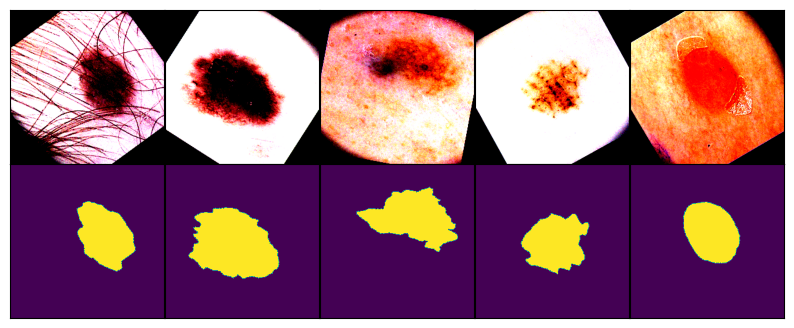

In [8]:
visualize_img_and_label(trainset)

# Model

# Train

In [9]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):

    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(F.sigmoid(Y_pred), Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(Y_pred, Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute().detach().cpu())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute().detach().cpu())

        
        print(f"Loss train: {avg_loss:.3f}\t Val Acc: {metric_dict['val_acc'].compute():.3f}\t, Val Dice: {metric_dict['val_dice'].compute()}")

    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute().detach().cpu())

    out_dict['train_loss'] = train_loss
    out_dict['val_loss'] = val_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [10]:
a = 0
for i in range(160):
    l, m = trainset.__getitem__(1)
    a += m.sum() 

# good weight is 11 
(256*256) /( a /160) 

tensor(5.1470, dtype=torch.float64)

In [11]:
# loss_function = {
# 'BCELoss':nn.BCEWithLogitsLoss(),
# 'BCELossWeighted':nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.14]).cuda()),
# 'FocalLoss':FocalLoss(),
# 'DiceLoss':DiceLoss(),
# }

# for loss_name, loss_fn in loss_function.items():
#     for aug in ['Augmentation', 'NoAugmentation']:
        
#         if aug == 'Augmentation':
#             trainset = PH2('train', transform=train_transform) # train_transform for augment
#         else:
#             trainset = PH2('train', transform=test_transform) # test_transform for no augment
            
#         valset = PH2('val', transform=test_transform)
#         testset = PH2('test', transform=test_transform)
        
#         train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
#         val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
#         test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)


#         model = UNet().to(device)
#         out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, num_epochs, train_loader, val_loader, test_loader)

#         plt.plot(np.arange(len(out_dict['train_dice'])), np.array(out_dict['train_dice'])) 
#         plt.plot(np.arange(len(out_dict['val_dice'])), np.array(out_dict['val_dice'])) 

#         out_dict['test_dice'] = np.repeat(out_dict['test_dice'], len(out_dict['train_dice']))
#         out_dict['test_iou'] = np.repeat(out_dict['test_iou'], len(out_dict['train_dice']))
#         out_dict['test_acc'] = np.repeat(out_dict['test_acc'], len(out_dict['train_dice']))
#         out_dict['test_sens'] = np.repeat(out_dict['test_sens'], len(out_dict['train_dice']))
#         out_dict['test_spec'] = np.repeat(out_dict['test_spec'], len(out_dict['train_dice']))

#         pd.DataFrame(out_dict).astype(float).to_csv(f"results/PH2/UNet_{aug}_{loss_name}")

#         im, lab = next(iter(test_loader))
#         out = model(im.cuda())
#         plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)
#         plt.show()
        

Loss train: 0.564	 Val Acc: 0.766	, Val Dice: 0.742653489112854
Loss train: 0.533	 Val Acc: 0.792	, Val Dice: 0.7535067200660706
Loss train: 0.521	 Val Acc: 0.784	, Val Dice: 0.751236081123352
Loss train: 0.523	 Val Acc: 0.778	, Val Dice: 0.7489951848983765
Loss train: 0.528	 Val Acc: 0.780	, Val Dice: 0.751723051071167
Loss train: 0.517	 Val Acc: 0.768	, Val Dice: 0.7442023158073425
Loss train: 0.515	 Val Acc: 0.774	, Val Dice: 0.7488794326782227
Loss train: 0.518	 Val Acc: 0.777	, Val Dice: 0.7523627877235413
Loss train: 0.508	 Val Acc: 0.785	, Val Dice: 0.759507954120636
Loss train: 0.511	 Val Acc: 0.790	, Val Dice: 0.7627527713775635
Loss train: 0.511	 Val Acc: 0.788	, Val Dice: 0.762944221496582
Loss train: 0.515	 Val Acc: 0.793	, Val Dice: 0.7673559784889221
Loss train: 0.508	 Val Acc: 0.798	, Val Dice: 0.7724887132644653
Loss train: 0.508	 Val Acc: 0.798	, Val Dice: 0.773315966129303
Loss train: 0.507	 Val Acc: 0.797	, Val Dice: 0.7729269862174988
Loss train: 0.515	 Val Acc: 0.7

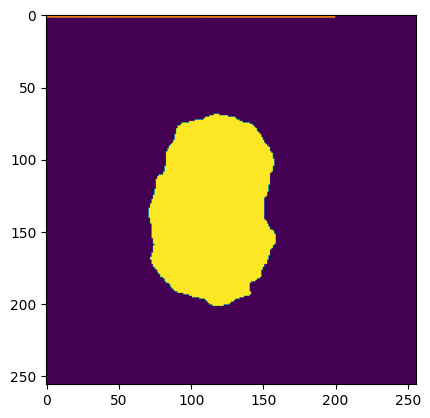

In [12]:
loss_function = {
'DiceLoss':DiceLoss(),
}

for loss_name, loss_fn in loss_function.items():
    for aug in ['Augmentation']:
        
        if aug == 'Augmentation':
            trainset = PH2('train', transform=train_transform) # train_transform for augment
        else:
            trainset = PH2('train', transform=test_transform) # test_transform for no augment
            
        valset = PH2('val', transform=test_transform)
        testset = PH2('test', transform=test_transform)
        
        train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
        val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
        test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)


        model = UNet().to(device)
        out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.001), loss_fn, num_epochs, train_loader, val_loader, test_loader)

        plt.plot(np.arange(len(out_dict['train_dice'])), np.array(out_dict['train_dice'])) 
        plt.plot(np.arange(len(out_dict['val_dice'])), np.array(out_dict['val_dice'])) 

        out_dict['test_dice'] = np.repeat(out_dict['test_dice'], len(out_dict['train_dice']))
        out_dict['test_iou'] = np.repeat(out_dict['test_iou'], len(out_dict['train_dice']))
        out_dict['test_acc'] = np.repeat(out_dict['test_acc'], len(out_dict['train_dice']))
        out_dict['test_sens'] = np.repeat(out_dict['test_sens'], len(out_dict['train_dice']))
        out_dict['test_spec'] = np.repeat(out_dict['test_spec'], len(out_dict['train_dice']))

        #pd.DataFrame(out_dict).astype(float).to_csv(f"results/PH2/UNet_{aug}_{loss_name}")

        im, lab = next(iter(test_loader))
        out = model(im.cuda())
        plt.imshow(F.sigmoid(out)[0].squeeze().detach().cpu() > 0.5)
        plt.show()
        

In [13]:
model

UNet(
  (enc_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample0): Upsample(size=32, mode='nearest')
  (dec_conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): Upsample(size=64, mode='nearest')
  (dec_conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1,

In [47]:
# 9, 15, 16
im, lab = testset.__getitem__(2)

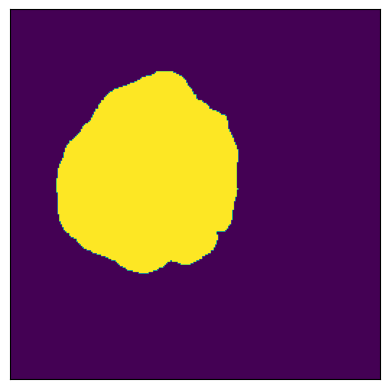

In [50]:
out = model(im.unsqueeze(0).cuda())
plt.imshow(F.sigmoid(out).squeeze().detach().cpu() > 0.5)
plt.xticks([])
plt.yticks([])
plt.savefig('PH2_016.png', pad_inches=0, transparent=True)

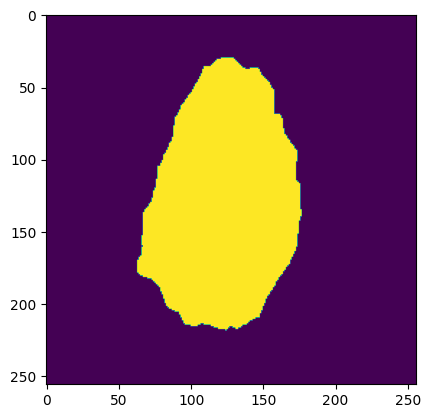

In [46]:
plt.imshow(lab)